In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pymoo.optimize import minimize
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PolynomialMutation
from pymoo.operators.sampling.lhs import LatinHypercubeSampling
from pymoo.termination import get_termination
from pymoo.visualization.scatter import Scatter
import seaborn as sns
from PymooOptimization import PortfolioOptimizationProblem
from distribution_calculator import DistributionCalculator
from dotenv.main import load_dotenv
import os

load_dotenv(override=True)

True

In [2]:
end_date = os.getenv("END_TRAIN_DATE")

In [3]:
def fetch_data_df():
    df = pd.read_csv('../../data/final_asset_classes.csv', index_col=0)
    df.index = pd.to_datetime(df.index)
    df = df[(df.index <= end_date)]
    return df


In [ ]:
prices_df = fetch_data_df()
returns_df = prices_df.pct_change(fill_method=None).dropna()
asset_names = prices_df.columns.tolist()

assets0 = 1000000
liabilities0 = 900000
alpha = 0.995

dist = DistributionCalculator(returns_df)

simulated_daily_returns, simulated_cumulative_returns = dist.prefered_dist()

problem = PortfolioOptimizationProblem(assets0, liabilities0, returns_df, alpha, simulated_daily_returns, simulated_cumulative_returns)

c:\Users\nicka\portfolio-opt-insurance\optimization\models\PymooOptimization.py:40: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_returns = self.returns_df.resample('Y').apply(lambda x: np.prod(1 + x) - 1)


In [ ]:
algorithm = NSGA2(
    pop_size=80,
    sampling=LatinHypercubeSampling(),
    crossover=SBX(prob=0.9, eta=90),
    mutation=PolynomialMutation(prob=0.5, eta=15),
    eliminate_duplicates=True
)

# Define termination criteria
termination = get_termination("n_gen", 100)

# Run optimization
start_time = time.time()
result = minimize(problem,
                    algorithm,
                    termination,
                    seed=42,
                    save_history=True,
                    verbose=True,
                    workers=-1)
end_time = time.time()

print(f"Optimization took {end_time - start_time:.2f} seconds.") 


Compiled modules for significant speedup can not be used!
https://pymoo.org/installation.html#installation

To disable this warning:
from pymoo.config import Config
Config.warnings['not_compiled'] = False

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |      1 |  0.3253480974 |  2.0001823949 |             - |             -
     2 |      200 |      1 |  0.1255283659 |  1.1824884366 |             - |             -
     3 |      300 |      1 |  0.1255283659 |  0.7793978961 |             - |             -
     4 |      400 |      1 |  0.0060445941 |  0.4525384774 |             - |             -
     5 |      500 |      1 |  0.0060445941 |  0.2135604365 |             - |             -
     6 |      600 |      1 |  0.0008363944 |  0.0930731073 |             - |             -
     7 |      700 |      1 |  0.0008363944 |  0.0428420054 |             - |             -
     8 |      800 |      1 |  0.000000E+00 |  0.0239060361 |     

## Storing The Result For Further Analysis

In [ ]:
from utils.append_to_json import append_to_json

In [ ]:
solutions = []
for i in range(len(result.X)):
    solution = {
        "weights": result.X[i].tolist(),
        "expected_return": -result.F[i, 1],
        "SCR_risk": result.F[i, 0],
        "risk_measure": os.getenv("RISK_MEASURE"),
        "distribution": os.getenv("DISTRIBUTION"),
        "period": (os.getenv("END_TRAIN_DATE"), os.getenv("END_SIMULATION_DATE"))
    }
    solutions.append(solution)

# Define the file path to store the results
json_file_path = "../pareto_front_results.json"

# Save the solutions to the JSON file
append_to_json(json_file_path, {
    "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
    "solutions": solutions
})

print(f"Results saved to {json_file_path}")

Results saved to ../pareto_front_results.json


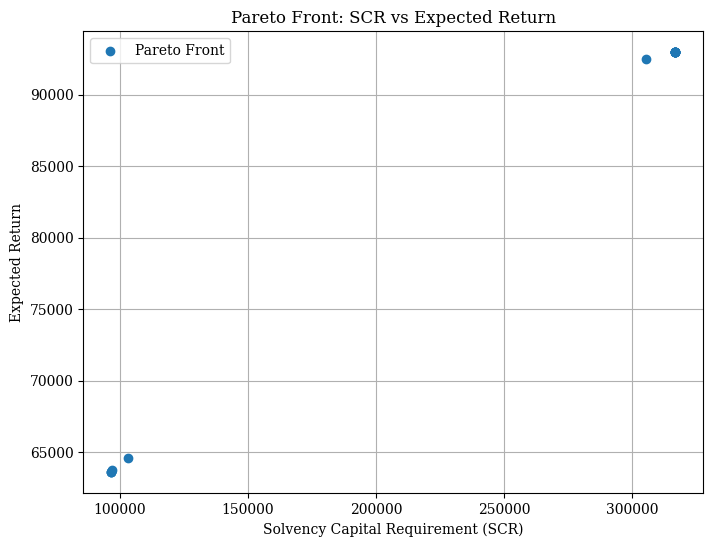

In [ ]:
plot = Scatter()
plot.add(result.F, label="Pareto Front")

plt.figure(figsize=(8, 6))  # Create a new figure
plt.scatter(result.F[:, 0], -result.F[:, 1], label="Pareto Front")
plt.title("Pareto Front: SCR vs Expected Return")
plt.xlabel("Solvency Capital Requirement (SCR)")
plt.ylabel("Expected Return")

plt.legend()
plt.grid(True)
plt.show()

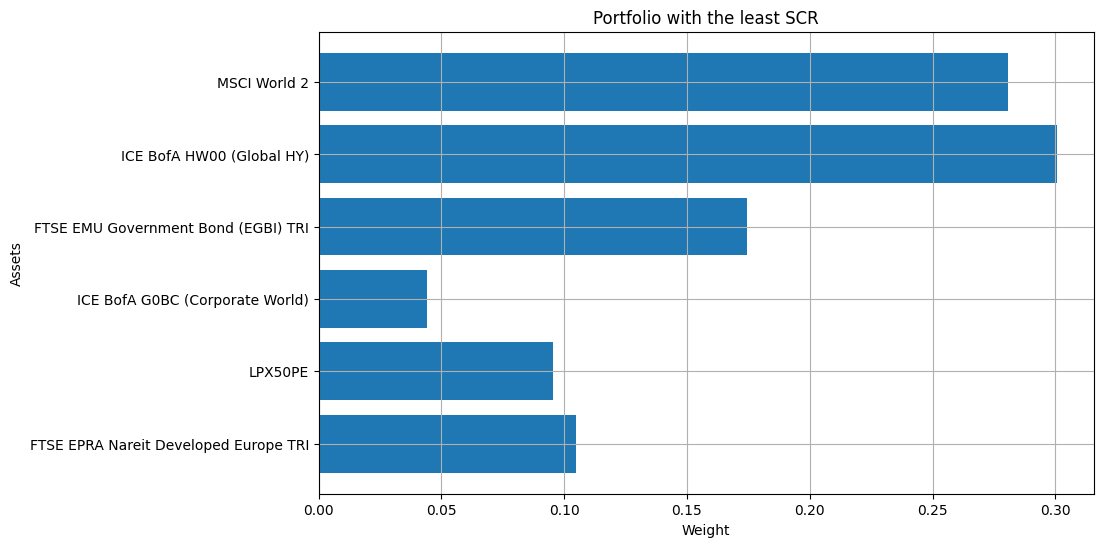

In [10]:
best_index = np.argmin(result.F[:, 0])  
best_weights = result.X[best_index]

plt.figure(figsize=(10, 6))
plt.barh(asset_names, best_weights)
plt.title("Portfolio with the least SCR")
plt.xlabel("Weight")
plt.ylabel("Assets")
plt.grid(True)

# For the x-axis, you can still avoid scientific notation if needed
plt.gca().get_xaxis().get_major_formatter().set_useOffset(False)  # For x-axis only

plt.show()

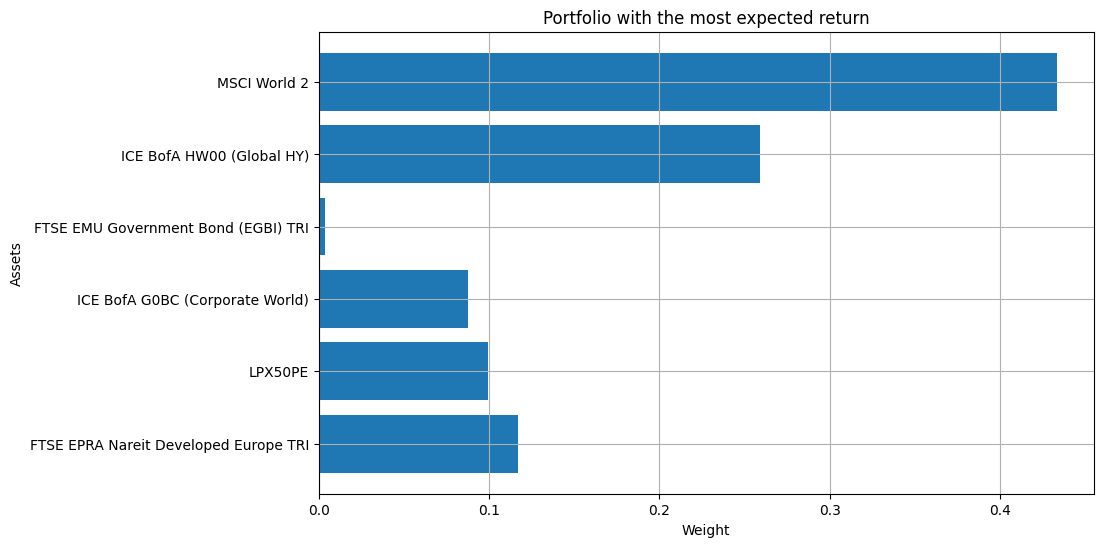

In [11]:
best_index = np.argmin(result.F[:, 1])  # Maximize expected return (Most risky)
best_weights = result.X[best_index]

plt.figure(figsize=(10, 6))
plt.barh(asset_names, best_weights)
plt.title("Portfolio with the most expected return")
plt.xlabel("Weight")
plt.ylabel("Assets")
plt.grid(True)

# For the x-axis, you can still avoid scientific notation if needed
plt.gca().get_xaxis().get_major_formatter().set_useOffset(False)  # For x-axis only

plt.show()

In [ ]:
print("\nBest Portfolio Allocation by Asset:")
portfolio_allocation = {asset: weight for asset, weight in zip(asset_names, best_weights)}
for asset, weight in portfolio_allocation.items():
    print(f"{asset}: {round(weight, 2)}")

print("Sum of weights:", np.sum(best_weights))

scr = abs(problem.calculate_scr(best_weights))
expected_return = problem.calculate_expected_return(best_weights)
print("\nExpected return over 1 year:", round(expected_return, 2))
print("\nSolvency Capital Requirement (SCR):", round(scr))



Best Portfolio Allocation by Asset:
FTSE EPRA Nareit Developed Europe TRI: 0.26
LPX50PE: 0.52
ICE BofA G0BC (Corporate World): 0.11
FTSE EMU Government Bond (EGBI) TRI: 0.02
ICE BofA HW00 (Global HY): 0.08
MSCI World 2: 0.02
Sum of weights: 1.0000803253110635

Expected return over 1 year: 92954.88

Solvency Capital Requirement (SCR): 316744


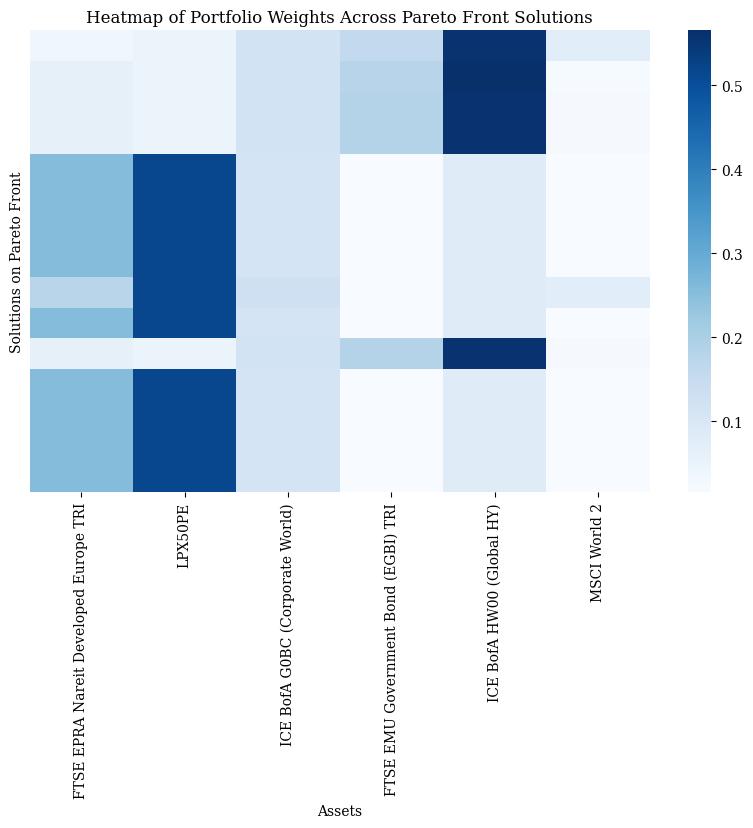

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(result.X, annot=False, cmap="Blues", xticklabels=asset_names, yticklabels=False)
plt.title("Heatmap of Portfolio Weights Across Pareto Front Solutions")
plt.xlabel("Assets")
plt.ylabel("Solutions on Pareto Front")
plt.show()

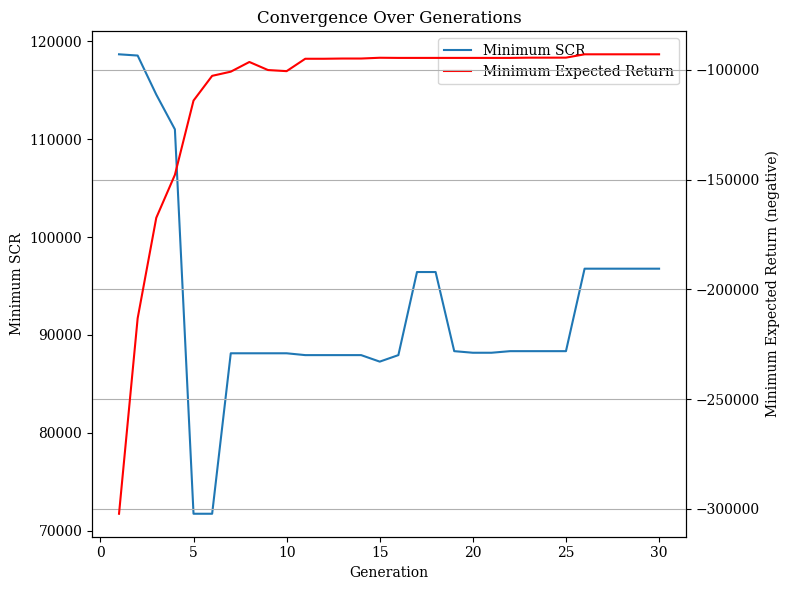

In [ ]:
n_gen = len(result.history)
cv_min = [entry.pop.get("F").min(axis=0) for entry in result.history]

# Separate the two objective functions (assuming index 0 corresponds to SCR and 1 to Expected Return)
scr_min = [f[0] for f in cv_min]
expected_return_min = [f[1] for f in cv_min]

# Plotting
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot SCR on left y-axis
scr_line, = ax1.plot(range(1, n_gen + 1), scr_min, label="Minimum SCR")
ax1.set_xlabel("Generation")
ax1.set_ylabel("Minimum SCR")
ax1.tick_params(axis='y')

# Create a second y-axis for Expected Return
ax2 = ax1.twinx()
expected_return_line, = ax2.plot(range(1, n_gen + 1), expected_return_min, label="Minimum Expected Return", color='red')
ax2.set_ylabel("Minimum Expected Return (negative)")
ax2.tick_params(axis='y')

# Combine the legends from both axes
lines = [scr_line, expected_return_line]
ax1.legend(lines, [line.get_label() for line in lines], loc="upper right")

# Add title and grid
plt.title("Convergence Over Generations")
fig.tight_layout()
plt.grid(True)
plt.show()


In [ ]:
problem2 = PortfolioOptimizationProblem(assets0, liabilities0, returns_df.iloc[:, :2], alpha, simulated_daily_returns, simulated_cumulative_returns)

TypeError: PortfolioOptimizationProblem.__init__() missing 2 required positional arguments: 'simulated_daily_returns' and 'simulated_cumulative_returns'

## Plotting The Objective Space

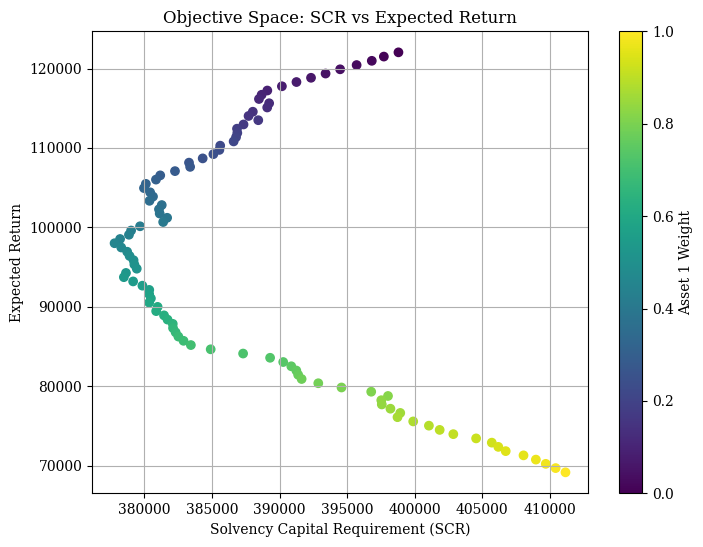

In [ ]:
# Assuming we have the two assets (Asset 1 and Asset 2)
# Create a grid of portfolio weights for Asset 1 (weights for Asset 2 will be 1 - w1)
w1_grid = np.linspace(0, 1, 100)  # Asset 1 weights from 0 to 1
w2_grid = 1 - w1_grid  # Asset 2 weights (since their sum must be 1)

# Initialize lists to store SCR and Expected Return for each portfolio combination
scr_values = []
expected_return_values = []

# Loop through each weight combination
for w1, w2 in zip(w1_grid, w2_grid):
    weights = np.array([w1, w2])
    
    # Calculate the SCR and Expected Return using your functions
    scr = abs(problem2.calculate_scr(weights))
    expected_return = problem2.calculate_expected_return(weights)
    
    # Store the calculated values
    scr_values.append(scr)
    expected_return_values.append(expected_return)

# Convert to numpy arrays for easy plotting
scr_values = np.array(scr_values)
expected_return_values = np.array(expected_return_values)

# Plot the SCR vs Expected Return as a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(scr_values, expected_return_values, c=w1_grid, cmap='viridis')
plt.colorbar(label='Asset 1 Weight')
plt.title("Objective Space: SCR vs Expected Return")
plt.xlabel("Solvency Capital Requirement (SCR)")
plt.ylabel("Expected Return")
plt.grid(True)
plt.show()
